In [ ]:
## Desafio Marcos Marçal - Ream

In [200]:
#Chamando os pacotes

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
import datetime
import requests
import zipfile
import io
import os
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [89]:
# URL de download
url = "https://www.jodidata.org/_resources/files/downloads/oil-data/world_secondary_csv.zip?iid=159"

# Pasta destino
destino = r"C:\Users\Marcos\Desktop\Marcos\Outros\Desafio_Tecnico\world_secondary_csv"
os.makedirs(destino, exist_ok=True)

# Download do zip
print("Baixando ...")
response = requests.get(url)
if response.status_code == 200:
    print("Download concluído!")

    #  Descompactar zip diretamente da memória
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall(destino)
        print(f"Arquivos extraídos para: {destino}")
else:
    print("Erro", response.status_code)


Baixando ...
Download concluído!
Arquivos extraídos para: C:\Users\Marcos\Desktop\Marcos\Outros\Desafio_Tecnico\world_secondary_csv


In [90]:
dados = r"C:\Users\Marcos\Desktop\Marcos\Outros\Desafio_Tecnico\world_secondary_csv\NewProcedure_Secondary_CSV.csv"
data_frame = pd.read_csv(dados)

In [91]:
# Analisando os nomes das colunas
print(data_frame.columns)

Index(['REF_AREA', 'TIME_PERIOD', 'ENERGY_PRODUCT', 'FLOW_BREAKDOWN',
       'UNIT_MEASURE', 'OBS_VALUE', 'ASSESSMENT_CODE'],
      dtype='object')


In [92]:
# Visualizando as primeiras linhas

print(data_frame.head(20))

   REF_AREA TIME_PERIOD ENERGY_PRODUCT FLOW_BREAKDOWN UNIT_MEASURE  OBS_VALUE  \
0        AE     2002-01        GASDIES        CLOSTLV      CONVBBL  7400.0000   
1        AE     2002-01        GASDIES        CLOSTLV         KBBL          -   
2        AE     2002-01        GASDIES        CLOSTLV          KBD          x   
3        AE     2002-01        GASDIES        CLOSTLV           KL          -   
4        AE     2002-01        GASDIES        CLOSTLV        KTONS          -   
5        AE     2002-01        GASDIES       IPTRANSF      CONVBBL        NaN   
6        AE     2002-01        GASDIES       IPTRANSF         KBBL        NaN   
7        AE     2002-01        GASDIES       IPTRANSF          KBD        NaN   
8        AE     2002-01        GASDIES       IPTRANSF           KL        NaN   
9        AE     2002-01        GASDIES       IPTRANSF        KTONS        NaN   
10       AE     2002-01        GASDIES        PTRANSF      CONVBBL        NaN   
11       AE     2002-01     

In [93]:
# Filtrando o dado de demanda (TOTDEMO) dos EUA (US) por barris por dia (KBD)

data_frame_filtrado = data_frame[
    (data_frame['REF_AREA'] == 'US') &
    (data_frame['FLOW_BREAKDOWN'] == 'TOTDEMO') &
    (data_frame['UNIT_MEASURE'] == 'KBD')
].copy()

# Converter data e corrigir inconsistências
data_frame_filtrado['date'] = pd.to_datetime(data_frame_filtrado['TIME_PERIOD'], format='%Y-%m')
data_frame_filtrado['Demand'] = pd.to_numeric(data_frame_filtrado['OBS_VALUE'], errors='coerce')
data_frame_filtrado = data_frame_filtrado[['date', 'ENERGY_PRODUCT', 'Demand']].dropna()

In [94]:
print(data_frame_filtrado['ENERGY_PRODUCT'].unique())

['GASDIES' 'GASOLINE' 'JETKERO' 'KEROSENE' 'LPG' 'NAPHTHA' 'ONONSPEC'
 'RESFUEL' 'TOTPRODS']


In [95]:
# Informações gerais
print(data_frame_filtrado.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2268 entries, 14083687 to 14209637
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            2268 non-null   datetime64[ns]
 1   ENERGY_PRODUCT  2268 non-null   object        
 2   Demand          2268 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 70.9+ KB
None


In [96]:
# Demanda por Gasoline
df_gasoline = data_frame_filtrado[data_frame_filtrado['ENERGY_PRODUCT'] == 'GASOLINE'].copy()

df_gasoline.head()

,date,ENERGY_PRODUCT,Demand
14097687,2002-01-01,GASOLINE,8309.0968
14097737,2002-02-01,GASOLINE,8685.9286
14097787,2002-03-01,GASOLINE,8761.9355
14097837,2002-04-01,GASOLINE,8838.6667
14097887,2002-05-01,GASOLINE,9170.8710


In [97]:
# Demanda por Middle Distillates (soma de GASDIES, JETKERO, KEROSENE)
middle_dist = ['GASDIES', 'JETKERO', 'KEROSENE']
df_middle = data_frame_filtrado[data_frame_filtrado['ENERGY_PRODUCT'].isin(middle_dist)].copy()
df_middle_sum = df_middle.groupby('date', as_index=False)['Demand'].sum()  # série mensal agregada

df_middle_sum.head()

,date,Demand
0,2002-01-01,5715.0645
1,2002-02-01,5431.2500
2,2002-03-01,5535.9355
3,2002-04-01,5603.8667
4,2002-05-01,5379.8710


In [171]:
# Dados Econômicos. Utilizado dados do FED. 'https://fred.stlouisfed.org/'

# Período com base nos dados JODI
start = datetime.datetime(2002, 1, 1)
end = datetime.datetime.today()

# Coleta de variáveis econômicas nos EUA via FRED
oil_price = web.DataReader('WTISPLC', 'fred', start, end)   # Preço do petróleo WTI
industrial_prod = web.DataReader('INDPRO', 'fred', start, end) # Produção industrial
vehicle_miles = web.DataReader('TRFVOLUSM227SFWA', 'fred', start, end) # Distância Percorrida pelos Veículos
freight_transp_serv = web.DataReader('TSIFRGHT', 'fred', start, end) # Índice dos Serviços de Transporte de Cargas
unemployment_rate = web.DataReader('UNRATE', 'fred', start, end) # Taxa de Desemprego (EUA)
cpi = web.DataReader('CPIAUCNS', 'fred', start, end)           # Índice de preços ao consumidor (CPI)

# Renomeando colunas
oil_price.columns = ['Oil_Price_WTI']
industrial_prod.columns = ['Industrial_Production']
vehicle_miles.columns = ['vehicle_miles']
freight_transp_serv.columns = ['Freight_Transp']
unemployment_rate.columns = ['Unemployment']
cpi.columns = ['CPI']

print(oil_price, industrial_prod, vehicle_miles ,freight_transp_serv, unemployment_rate, cpi)

            Oil_Price_WTI
DATE                     
2002-01-01          19.67
2002-02-01          20.74
2002-03-01          24.42
2002-04-01          26.27
2002-05-01          27.02
...                   ...
2025-01-01          75.74
2025-02-01          71.53
2025-03-01          68.24
2025-04-01          63.54
2025-05-01          62.17

[281 rows x 1 columns]             Industrial_Production
DATE                             
2002-01-01                88.4634
2002-02-01                88.4578
2002-03-01                89.1265
2002-04-01                89.5507
2002-05-01                89.9348
...                           ...
2025-01-01               102.9343
2025-02-01               104.0003
2025-03-01               103.7483
2025-04-01               103.8216
2025-05-01               103.5948

[281 rows x 1 columns]             vehicle_miles
DATE                     
2002-01-01         236712
2002-02-01         238125
2002-03-01         235504
2002-04-01         236391
2002-05-01      

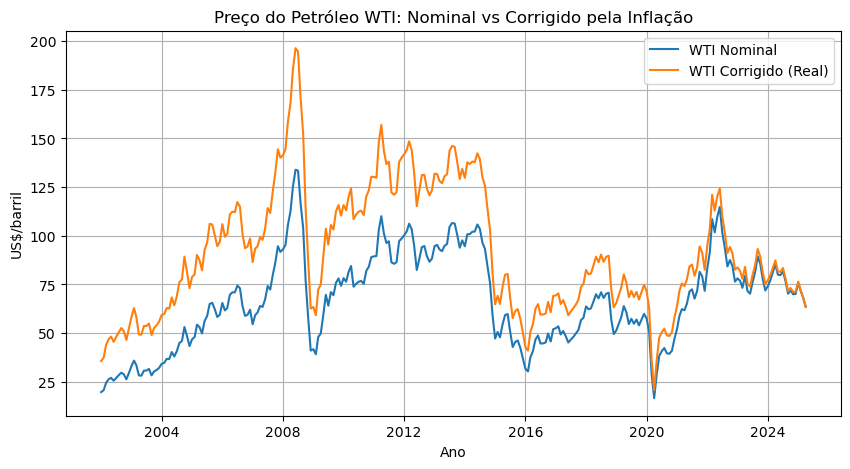

In [148]:
# Criando coluna do WTI ajustado pela inflação (# WTI_real). 
cpi_ref = econ_data['CPI'].iloc[-1]  # CPI do último mês da base (moeda constante mais recente)
econ_data['WTI_real'] = econ_data['Oil_Price_WTI'] * (cpi_ref / econ_data['CPI'])

plt.figure(figsize=(10,5))
plt.plot(econ_data['date'], econ_data['Oil_Price_WTI'], label='WTI Nominal')
plt.plot(econ_data['date'], econ_data['WTI_real'], label='WTI Corrigido (Real)')
plt.legend()
plt.title('Preço do Petróleo WTI: Nominal vs Corrigido pela Inflação')
plt.xlabel('Ano')
plt.ylabel('US$/barril')
plt.grid()
plt.show()

# Esse ponto é necessário nas modelagens à frente #

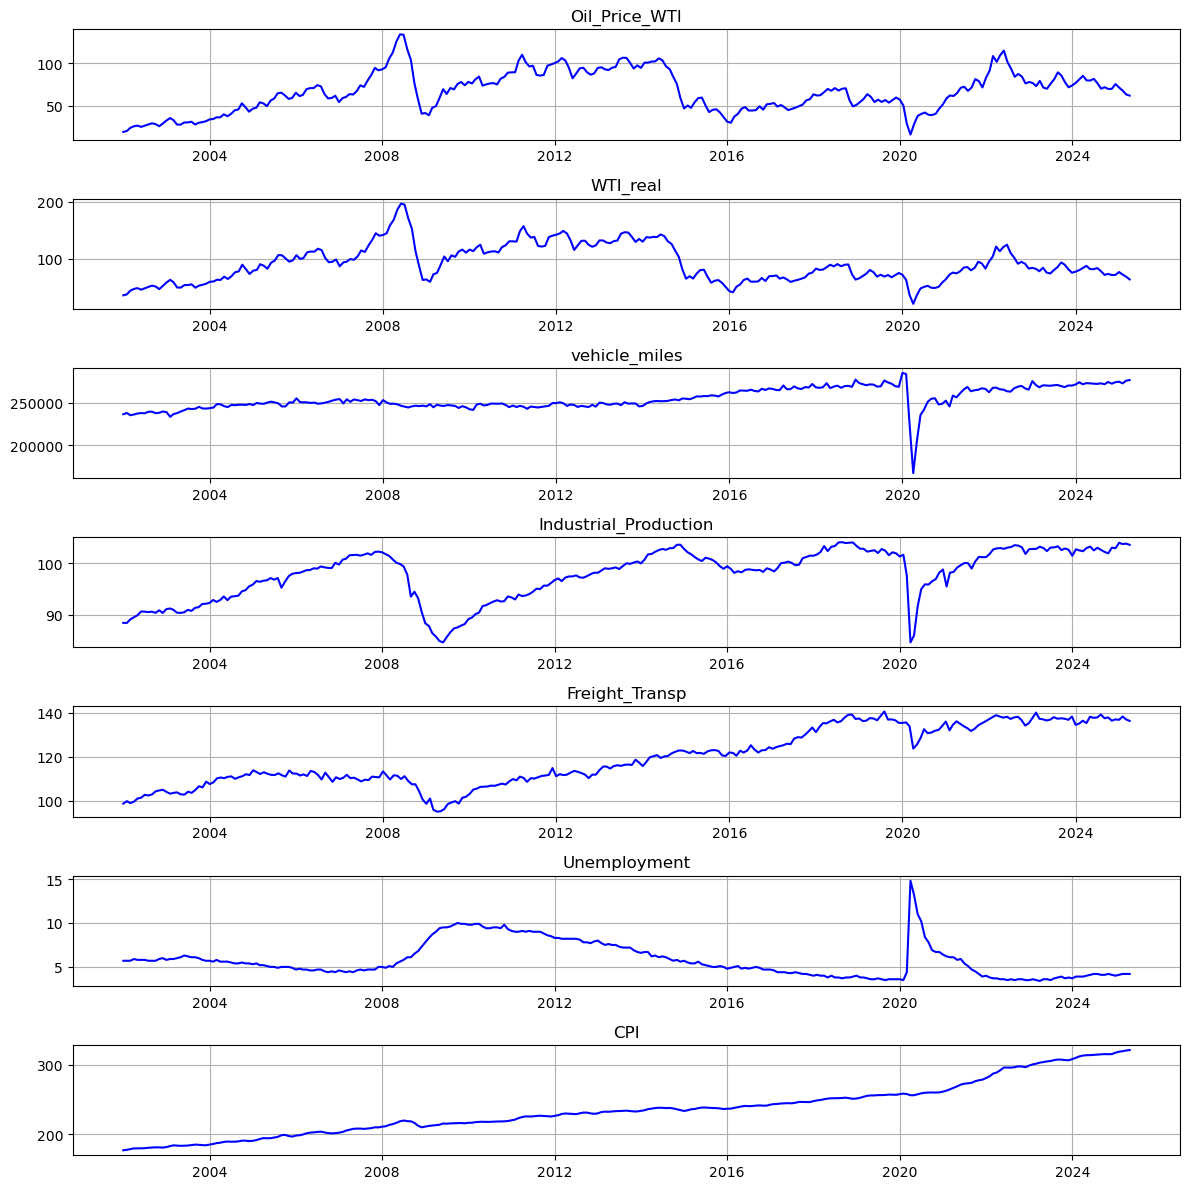

In [172]:
# Análise Gráfica
WTI_real = econ_data.set_index('date')[['WTI_real']]
series = {
    'Oil_Price_WTI': oil_price,
    'WTI_real': WTI_real,
    'vehicle_miles': vehicle_miles,
    'Industrial_Production': industrial_prod,
    'Freight_Transp': freight_transp_serv,
    'Unemployment': unemployment_rate,
    'CPI': cpi
}


plt.figure(figsize=(12, 12))

for i, (label, data) in enumerate(series.items(), 1):
    plt.subplot(len(series), 1, i)
    plt.plot(data.index, data.iloc[:, 0], marker='', color='b')
    plt.title(label)
    plt.grid(True)
    plt.tight_layout()

plt.show()

In [174]:
# Agregando  os dados econômicos pelo índice (DATE)
econ_data = oil_price.join([industrial_prod, vehicle_miles, freight_transp_serv, unemployment_rate, cpi], how='inner').reset_index()
econ_data = econ_data.rename(columns={'DATE': 'date'})

# Acrescentando o WTI real no dataframe
cpi_ref = econ_data['CPI'].iloc[-1]
econ_data['WTI_real'] = econ_data['Oil_Price_WTI'] * (cpi_ref / econ_data['CPI'])
print(econ_data.columns)

Index(['date', 'Oil_Price_WTI', 'Industrial_Production', 'vehicle_miles',
       'Freight_Transp', 'Unemployment', 'CPI', 'WTI_real'],
      dtype='object')


In [175]:
#Verificando se há valores faltantes
print(df.isnull().sum())

date                     0
ENERGY_PRODUCT           0
value                    0
Oil_Price_WTI            0
Industrial_Production    0
Freight_Transp           0
Unemployment             0
CPI                      0
dtype: int64


In [176]:
df_gasoline_final   = pd.merge(df_gasoline[['date', 'Demand']], econ_data, on='date', how='inner')
df_middle_final     = pd.merge(df_middle_sum, econ_data, on='date', how='inner')

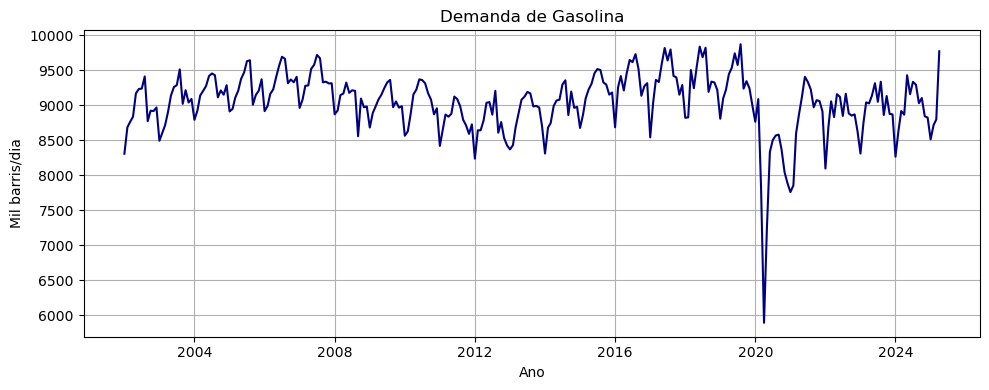

In [190]:
# Grafico demanda gasolina
plt.figure(figsize=(10,4))
plt.plot(df_gasoline_final['date'], df_gasoline_final['Demand'], color='navy')
plt.title('Demanda de Gasolina')
plt.xlabel('Ano')
plt.ylabel('Mil barris/dia')
plt.grid(True)
plt.tight_layout()
plt.show()

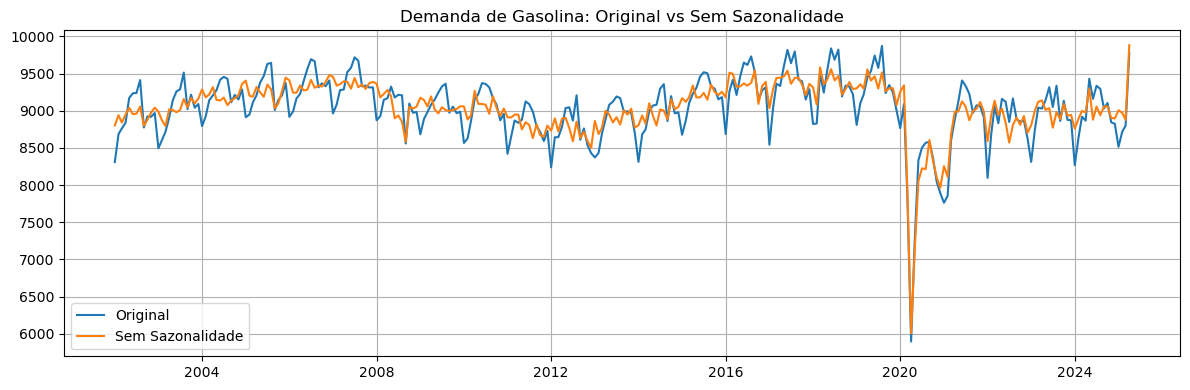

In [192]:
# Os dados da demanda de gasolina parecem ter um componente sazonal forte. Verificando.

from statsmodels.tsa.seasonal import seasonal_decompose

demanda = df_gasoline_final.set_index('date')['Demand']

# Decompor: modelo aditivo
result = seasonal_decompose(demanda, model='additive', period=12)  # 12 meses para anual

# Série sem a sazonalidade
demanda_adjusted = demanda - result.seasonal

# Para visualizar o ajuste:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(demanda.index, demanda, label='Original')
plt.plot(demanda.index, demanda_adjusted, label='Sem Sazonalidade')
plt.legend()
plt.title('Demanda de Gasolina: Original vs Sem Sazonalidade')
plt.grid()
plt.tight_layout()
plt.show()

In [177]:
# Correlação Gasolina
print(df_gasoline_final.corr(numeric_only=True)['Demand'].sort_values(ascending=False))

Demand                   1.000000
vehicle_miles            0.428840
Industrial_Production    0.249086
WTI_real                 0.044827
Oil_Price_WTI           -0.010274
Freight_Transp          -0.022687
CPI                     -0.139622
Unemployment            -0.421643
Name: Demand, dtype: float64


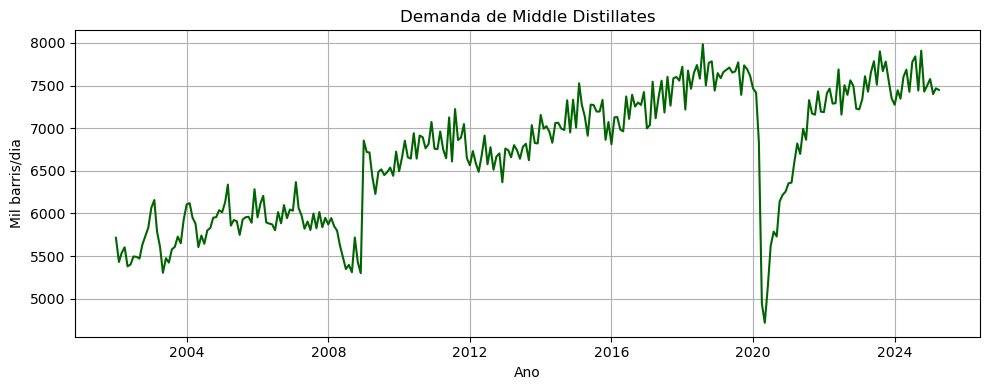

In [191]:
# Demanda de Middle
plt.figure(figsize=(10,4))
plt.plot(df_middle_final['date'], df_middle_final['Demand'], color='darkgreen')
plt.title('Demanda de Middle Distillates')
plt.xlabel('Ano')
plt.ylabel('Mil barris/dia')
plt.grid(True)
plt.tight_layout()
plt.show()

In [178]:
# Correlação Destilados
print(df_middle_final.corr(numeric_only=True)['Demand'].sort_values(ascending=False))

Demand                   1.000000
vehicle_miles            0.779893
CPI                      0.743907
Freight_Transp           0.726803
Industrial_Production    0.628073
Oil_Price_WTI            0.265168
WTI_real                -0.025736
Unemployment            -0.382803
Name: Demand, dtype: float64


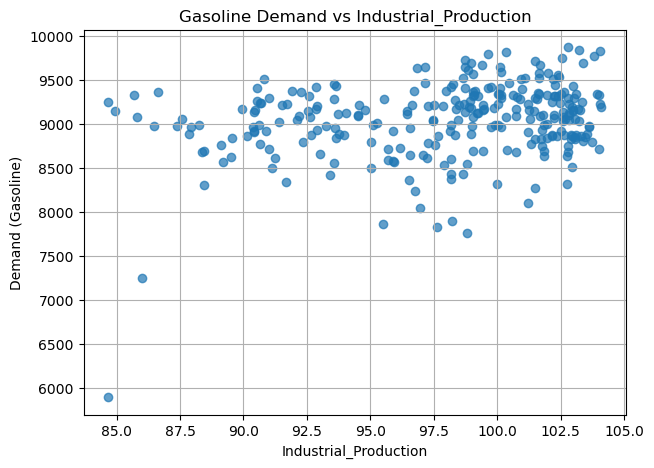

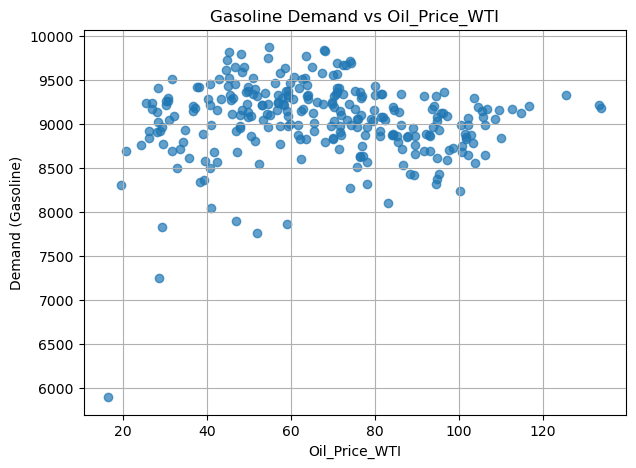

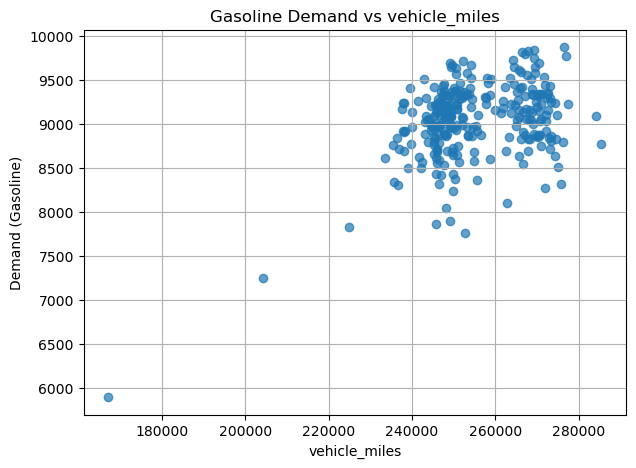

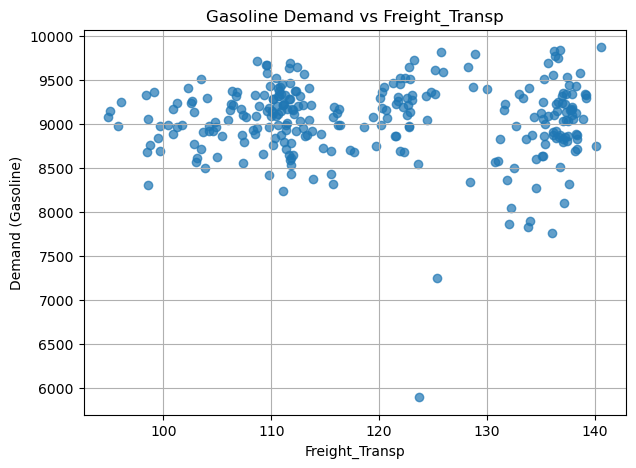

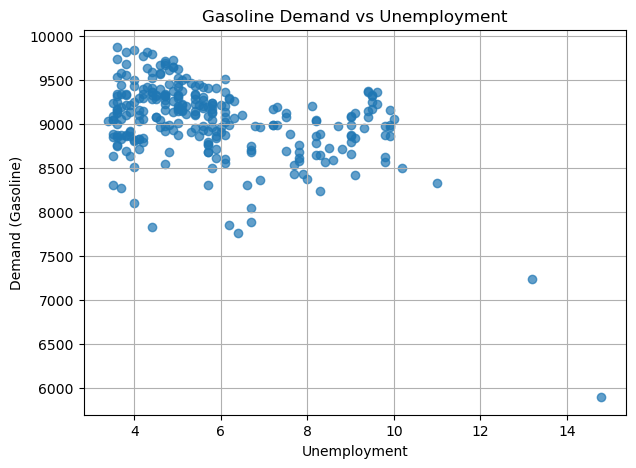

In [179]:
for col in ['Industrial_Production','Oil_Price_WTI', 'vehicle_miles','Freight_Transp', 'Unemployment']:
    plt.figure(figsize=(7, 5))
    plt.scatter(df_gasoline_final[col], df_gasoline_final['Demand'], alpha=0.7)
    plt.xlabel(col)
    plt.ylabel('Demand (Gasoline)')
    plt.title(f'Gasoline Demand vs {col}')
    plt.grid(True)
    plt.show()

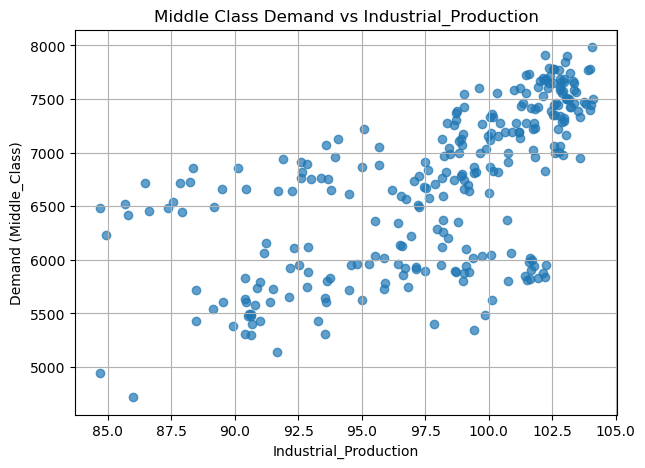

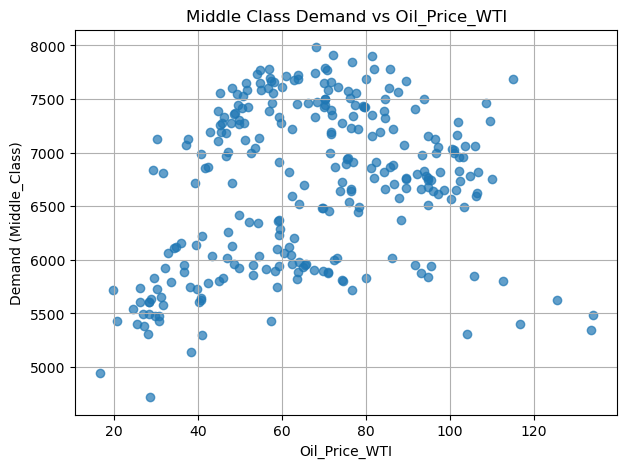

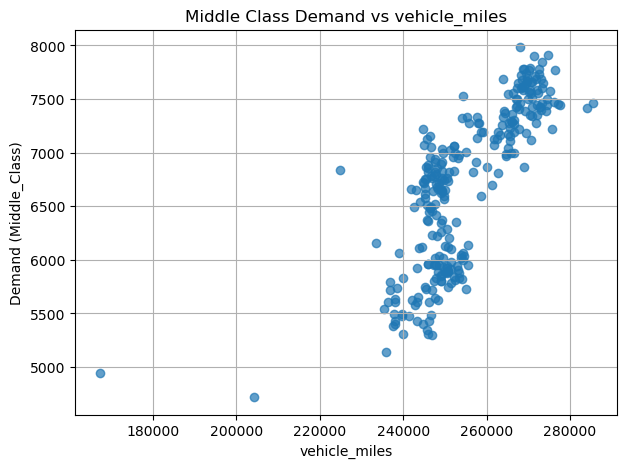

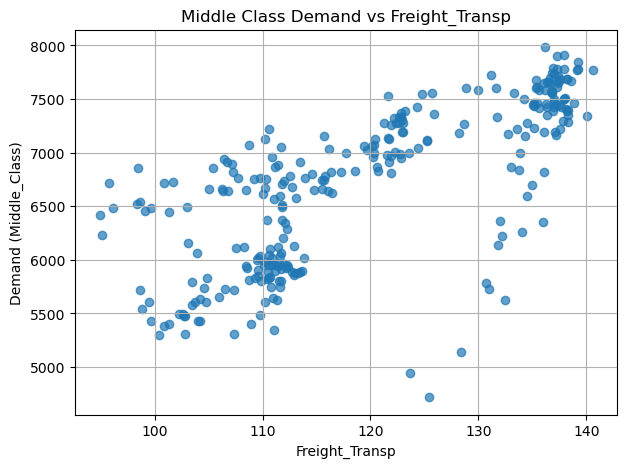

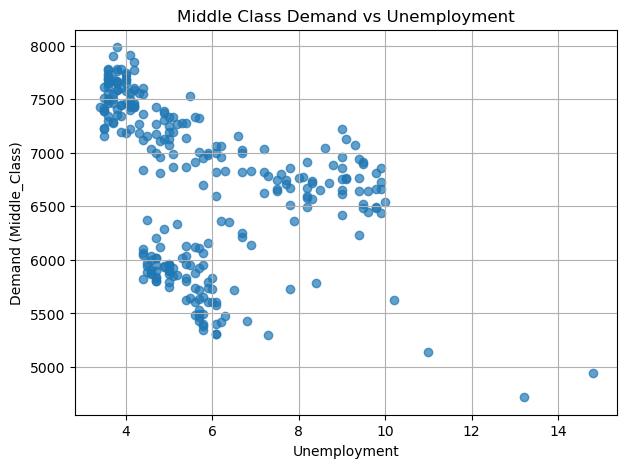

In [180]:
for col in ['Industrial_Production','Oil_Price_WTI', 'vehicle_miles', 'Freight_Transp', 'Unemployment']:
    plt.figure(figsize=(7, 5))
    plt.scatter(df_middle_final[col], df_middle_final['Demand'], alpha=0.7)
    plt.xlabel(col)
    plt.ylabel('Demand (Middle_Class)')
    plt.title(f'Middle Class Demand vs {col}')
    plt.grid(True)
    plt.show()

In [181]:
def lagged_corr_heatmap(df, target_col, feature_cols, max_lag=6):
    "Gera e plota um heatmap de correlação da variável alvo com features, usando lags de 0 até max_lag."
    corr_dict = {}
    for var in feature_cols:
        corrs = []
        for lag in range(max_lag + 1):
            corrs.append(df[target_col].corr(df[var].shift(lag)))
        corr_dict[var] = corrs
    corr_matrix = pd.DataFrame(corr_dict, index=[f"Lag {i}" for i in range(max_lag+1)])
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f'Correlação da Demanda com Variáveis Econômicas em diferentes Lags')
    plt.xlabel('Variáveis Econômicas')
    plt.ylabel('Defasagem (Lag)')
    plt.tight_layout()
    plt.show()
    return corr_matrix

Matriz de Correlação - Gasoline:
                         Demand  Oil_Price_WTI  WTI_real  \
Demand                 1.000000      -0.010274  0.044827   
Oil_Price_WTI         -0.010274       1.000000  0.921374   
WTI_real               0.044827       0.921374  1.000000   
Industrial_Production  0.249086       0.381686  0.156209   
vehicle_miles          0.428840       0.154956 -0.108101   
Freight_Transp        -0.022687       0.115537 -0.224863   
Unemployment          -0.421643       0.109074  0.268706   
CPI                   -0.139622       0.319660 -0.062058   

                       Industrial_Production  vehicle_miles  Freight_Transp  \
Demand                              0.249086       0.428840       -0.022687   
Oil_Price_WTI                       0.381686       0.154956        0.115537   
WTI_real                            0.156209      -0.108101       -0.224863   
Industrial_Production               1.000000       0.742158        0.770030   
vehicle_miles                  

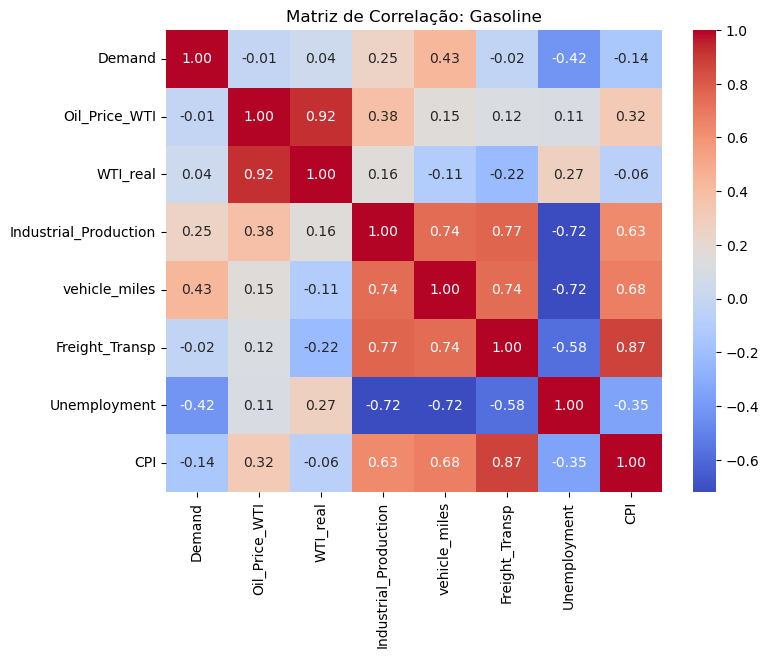

In [182]:
# Matriz de correlação Gasolina

cols = ['Demand', 'Oil_Price_WTI', 'WTI_real', 'Industrial_Production', 'vehicle_miles','Freight_Transp', 'Unemployment', 'CPI']
corr_matrix_gasoline = df_gasoline_final[cols].corr()

print("Matriz de Correlação - Gasoline:")
print(corr_matrix_gasoline)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_gasoline, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matriz de Correlação: Gasoline")
plt.show()

Matriz de Correlação - Middle Distillates:
                         Demand  Oil_Price_WTI  WTI_real  \
Demand                 1.000000       0.265168 -0.025736   
Oil_Price_WTI          0.265168       1.000000  0.921374   
WTI_real              -0.025736       0.921374  1.000000   
Industrial_Production  0.628073       0.381686  0.156209   
vehicle_miles          0.779893       0.154956 -0.108101   
Freight_Transp         0.726803       0.115537 -0.224863   
Unemployment          -0.382803       0.109074  0.268706   
CPI                    0.743907       0.319660 -0.062058   

                       Industrial_Production  vehicle_miles  Freight_Transp  \
Demand                              0.628073       0.779893        0.726803   
Oil_Price_WTI                       0.381686       0.154956        0.115537   
WTI_real                            0.156209      -0.108101       -0.224863   
Industrial_Production               1.000000       0.742158        0.770030   
vehicle_miles        

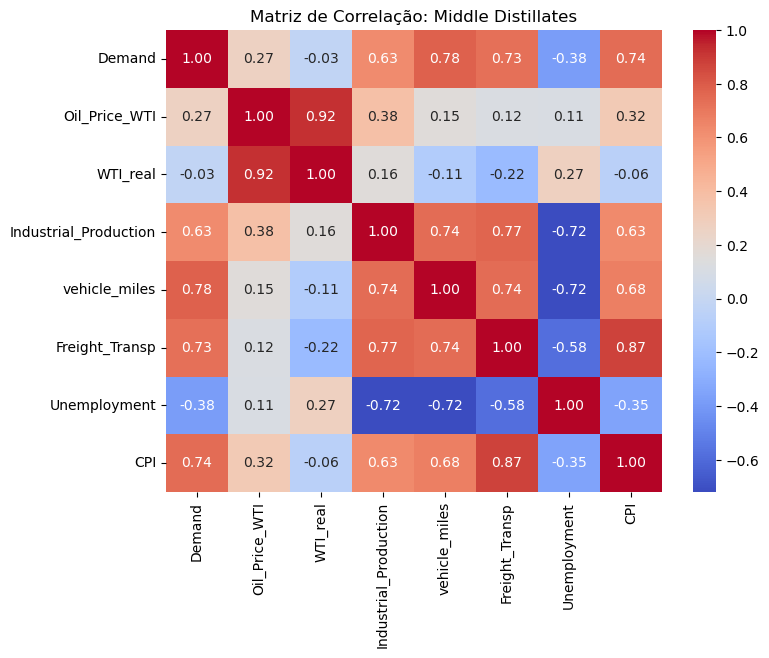

In [183]:
# Matriz de Correlação - Middle

cols = ['Demand', 'Oil_Price_WTI', 'WTI_real', 'Industrial_Production', 'vehicle_miles', 'Freight_Transp', 'Unemployment', 'CPI']
corr_matrix_middle = df_middle_final[cols].corr()

print("Matriz de Correlação - Middle Distillates:")
print(corr_matrix_middle)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_middle, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matriz de Correlação: Middle Distillates")
plt.show()

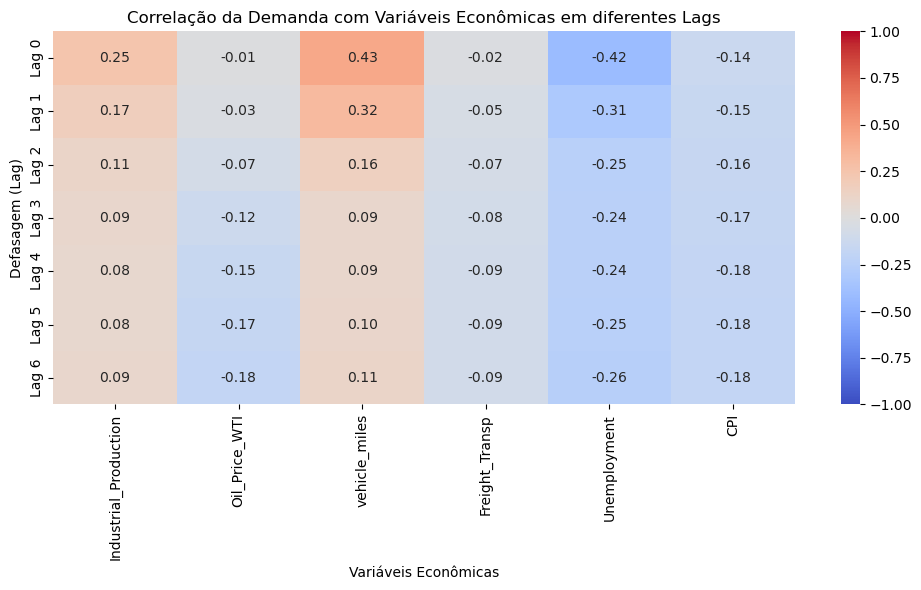

In [184]:
# Matriz de Correlação em diferentes Lags - Gasolina

feature_cols = ['Industrial_Production', 'Oil_Price_WTI', 'vehicle_miles', 'Freight_Transp', 'Unemployment', 'CPI']
corr_mat = lagged_corr_heatmap(df_gasoline_final, 'Demand', feature_cols, max_lag=6)

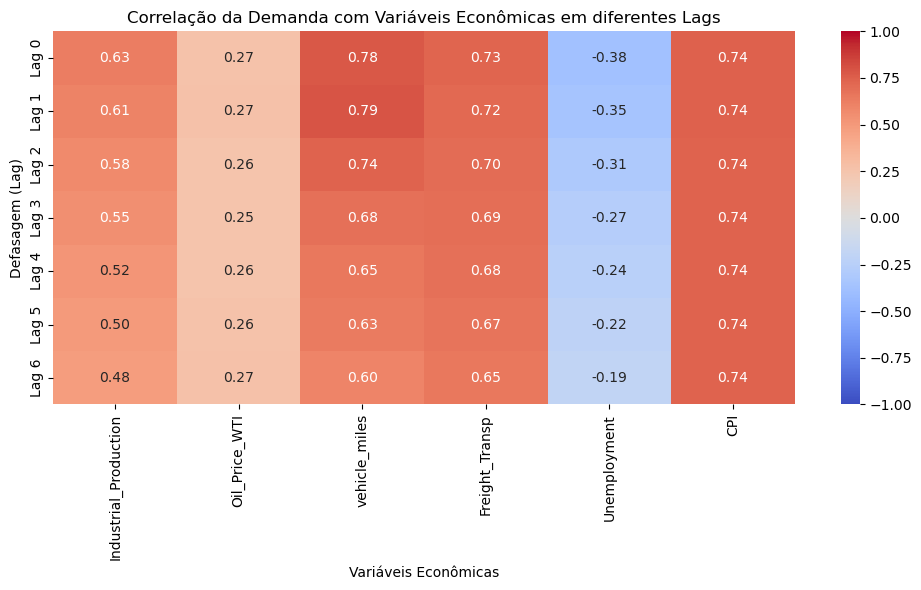

In [185]:
# Matriz de Correlação em diferentes Lags - Middle
feature_cols = ['Industrial_Production', 'Oil_Price_WTI', 'vehicle_miles', 'Freight_Transp', 'Unemployment', 'CPI']
corr_mat = lagged_corr_heatmap(df_middle_final, 'Demand', feature_cols, max_lag=6)

In [212]:
## 2 Modelagem Preditiva

# Realizando inicialmente uma modelagem com um OLS (muk)

# Gasolina

# Acrescentando dummies de crise de 2008 e pandemia
df_gasoline_final['pandemic_dummy'] = ((df_gasoline_final['date'] >= '2020-03-01') & (df_gasoline_final['date'] <= '2021-06-01')).astype(int)
df_gasoline_final['crisis_2008_dummy'] = ((df_gasoline_final['date'] >= '2008-09-01') & (df_gasoline_final['date'] <= '2009-06-01')).astype(int)

cols = ['Demand', 'WTI_real', 'Industrial_Production', 'vehicle_miles', 'Freight_Transp', 'Unemployment', 'CPI', 'pandemic_dummy', 'crisis_2008_dummy']
df_gasoline_clean = df_gasoline_final.dropna(subset=cols)

X = df_gasoline_clean[['WTI_real', 'Industrial_Production', 'vehicle_miles', 'Freight_Transp', 'Unemployment', 'CPI', 'pandemic_dummy', 'crisis_2008_dummy']]
y = df_gasoline_clean['Demand']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     42.04
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           2.43e-43
Time:                        21:09:58   Log-Likelihood:                -1981.5
No. Observations:                 280   AIC:                             3981.
Df Residuals:                     271   BIC:                             4014.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3336.98

Como ponto de partida, estimei um modelo OLS para a demanda mensal de gasolina nos EUA, incluindo como explicativas: preço real do petróleo (WTI ajustado pela inflação), produção industrial, milhas rodadas por veículos, índice de transporte de cargas, desemprego, inflação (CPI), além de dummies para pandemia e crise de 2008.

O modelo obteve um R² de 0,55, explicando de forma razoavel a variabilidade dos dados de demanda no período. Entre as variáveis, milhas rodadas mostrou-se altamente significativa (coeficiente positivo e t elevado), assim como o CPI, que teve impacto negativo e estatisticamente relevante. Já o preço do petróleo, desemprego e as dummies de crise não se mostraram significativos nessa primeira especificação.

Embora os sinais estejam condizentes com a intuição econômica, o resultado também sugere a presença de multicolinearidade e possível necessidade de outros ajustes, como transformação ou análise de sazonalidade, para refinar as estimativas. Ainda assim, o teste cumpre o papel inicial de identificar os principais drivers da demanda, servindo de base para os próximos modelos.

In [217]:
# Verificando a demanda de Gasolina mas de acordo com a série ajustada sazonalmente.

# Criando um DataFrame separado para o ajuste
df_gasoline_final2 = df_gasoline_final.copy()

# Ajuste sazonal da demanda (garantindo datas únicas e ordenadas)
demanda = df_gasoline_final2.set_index('date')['Demand'].sort_index()
result = seasonal_decompose(demanda, model='additive', period=12)
demanda_adjusted = demanda - result.seasonal

# Adiciona o resultado de volta ao DataFrame, alinhando por data
df_gasoline_final2 = df_gasoline_final2.merge(
    demanda_adjusted.rename('demanda_adjusted'), on='date', how='left'
)

# Definindo X e y para a regressão
cols = ['demanda_adjusted', 'WTI_real', 'Industrial_Production', 'vehicle_miles',
        'Freight_Transp', 'Unemployment', 'CPI', 'pandemic_dummy', 'crisis_2008_dummy']

# Limpando possível NaN
df_gasoline_limpo2 = df_gasoline_final2.dropna(subset=cols)

X = df_gasoline_limpo2[['WTI_real', 'Industrial_Production', 'vehicle_miles',
                        'Freight_Transp', 'Unemployment', 'CPI', 'pandemic_dummy', 'crisis_2008_dummy']]
y = df_gasoline_limpo2['demanda_adjusted']
X = sm.add_constant(X)

# Modelo OLS
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       demanda_adjusted   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     169.2
Date:                Sun, 29 Jun 2025   Prob (F-statistic):          1.04e-100
Time:                        21:14:51   Log-Likelihood:                -1795.1
No. Observations:                 280   AIC:                             3608.
Df Residuals:                     271   BIC:                             3641.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3030.25

O modelo mostra que a demanda de gasolina nos EUA é fortemente influenciada pelo volume de milhas rodadas pelos veículos — movimento intuitivo: quanto mais a frota circula, mais se consome gasolina. A produção industrial também pesa de forma positiva. Já o preço do petróleo, mesmo ajustado pela inflação, não se mostrou estatisticamente relevante nesse período. A pandemia teve um impacto claro, derrubando a demanda, enquanto as demais variáveis tiveram efeito mais discreto. O ajuste do modelo ficou bastante bom, com um R² relativamente elevado (83,3%).

In [187]:
# Middle

# Acrescentando dummies de crise de 2008 e pandemia
df_middle_final['pandemic_dummy'] = ((df_middle_final['date'] >= '2020-03-01') & (df_middle_final['date'] <= '2021-06-01')).astype(int)
df_middle_final['crisis_2008_dummy'] = ((df_middle_final['date'] >= '2008-09-01') & (df_middle_final['date'] <= '2009-06-01')).astype(int)


cols = ['Demand', 'WTI_real', 'Industrial_Production', 'Freight_Transp', 'Unemployment', 'CPI', 'pandemic_dummy', 'crisis_2008_dummy']
# Removendo possíveis linhas com NaN
df_middle_clean = df_middle_final.dropna(subset=cols)

X_middle = df_middle_clean[['WTI_real', 'Industrial_Production', 'Freight_Transp', 'Unemployment', 'CPI', 'pandemic_dummy', 'crisis_2008_dummy']]
y_middle = df_middle_clean['Demand']
X_middle = sm.add_constant(X_middle)

model_middle = sm.OLS(y_middle, X_middle).fit()
print(model_middle.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     133.3
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           4.30e-84
Time:                        19:14:26   Log-Likelihood:                -2038.6
No. Observations:                 280   AIC:                             4093.
Df Residuals:                     272   BIC:                             4122.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3664.21

Para os destilados médios, a ligação com o transporte de cargas ficou mais evidente: o índice de frete foi o principal fator de impacto sobre a demanda, seguido pela produção industrial e pela taxa de desemprego. O preço do petróleo aparece com efeito negativo e estatisticamente significativo — ou seja, indicando que preços mais altos tendem a conter o consumo. A pandemia afetou bastante o setor, como já esperado. O modelo também mostrou bom ajuste, com explicação sólida da variação da demanda.

In [219]:
# 2.1) Modelagem usando Sarimax (sem variáveis exógenas)

from statsmodels.tsa.statespace.sarimax import SARIMAX

         # p: auto-regressivo

         # d: diferenças

         # q: média móvel

         # P, D, Q: equivalentes sazonais

         # s: periodicidade (12 para dados mensais)

serie = df_gasoline_final.set_index('date')['Demand'].sort_index()
modelo = SARIMAX(serie, order=(1,1,1), seasonal_order=(1,1,1,12))
resultado = modelo.fit(disp=False)

print(resultado.summary())
            

C:\Users\Marcos\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Marcos\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             Demand   No. Observations:                  280
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1852.972
Date:                            Sun, 29 Jun 2025   AIC                           3715.944
Time:                                    21:27:01   BIC                           3733.881
Sample:                                01-01-2002   HQIC                          3723.149
                                     - 04-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8056      0.029     27.458      0.000       0.748       0.863
ma.L1         -0.9981      0.207   

Esse ARIMA (1,1,1)x(1,1,1,12) consegue capturar bem a dinâmica da demanda de gasolina, principalmente ciclos anuais e choques de curto prazo. Para previsão pura de demanda (sem causas econômicas explícitas), o modelo é sólido, mas não traz explicação econômica dos movimentos — apenas a dinâmica interna da série.

In [226]:
# 2.2) Testando Sarimax para demanda de Gasolina (com variáveis exógenas)

from statsmodels.tsa.statespace.sarimax import SARIMAX

# df_gasoline_final já tem todas as variáveis
serie = df_gasoline_final.set_index('date')['Demand'].sort_index()

exog_vars = df_gasoline_final.set_index('date')[['WTI_real', 'Industrial_Production', 'vehicle_miles']]
exog_vars = exog_vars.loc[serie.index]  # Garante alinhamento

# Remove NaNs (tanto da série quanto das exógenas)
mask = (~serie.isna()) & (~exog_vars.isna().any(axis=1))
serie = serie[mask]
exog_vars = exog_vars[mask]

modelo = SARIMAX(serie, 
                 exog=exog_vars,
                 order=(1,1,1), 
                 seasonal_order=(1,1,1,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False)

resultado = modelo.fit(disp=False, maxiter=200)
print(resultado.summary())

C:\Users\Marcos\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Marcos\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             Demand   No. Observations:                  280
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1606.181
Date:                            Sun, 29 Jun 2025   AIC                           3228.362
Time:                                    21:46:43   BIC                           3256.629
Sample:                                01-01-2002   HQIC                          3239.734
                                     - 04-01-2025                                         
Covariance Type:                              opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
WTI_real                 -1.9272      0.773     -2.493      0.013      -3.442      -0.412
In

O modelo SARIMAX com as variáveis econômicas WTI_real, Produção Industrial e vehicle_miles como explicativas trouxe avanços importantes:

Todos os coeficientes exógenos são estatisticamente significativos. Isso indica que, além do padrão temporal e sazonal da série, esses fatores econômicos ajudam a explicar a dinâmica da demanda por gasolina.

* O preço do WTI ajustado pela inflação (WTI_real) tem efeito negativo e significativo sobre a demanda — ou seja, aumentos reais no preço do petróleo tendem a reduzir o consumo.

* A produção industrial também tem impacto positivo, mostrando conexão entre atividade econômica e consumo de combustível.

* O volume de milhas percorridas por veículos (vehicle_miles) aparece como o fator mais relevante para a variação da demanda, como esperado.

* Os parâmetros autorregressivo e de média móvel (e suas versões sazonais) capturam bem as dependências temporais.

* O AIC (3228) melhorou bastante em relação ao ARIMA puro, mostrando ganho ao incluir informação econômica no modelo.

Resíduos estão razoavelmente comportados, embora haja algum grau de heterocedasticidade e desvio da normalidade (comum em séries econômicas com choques).

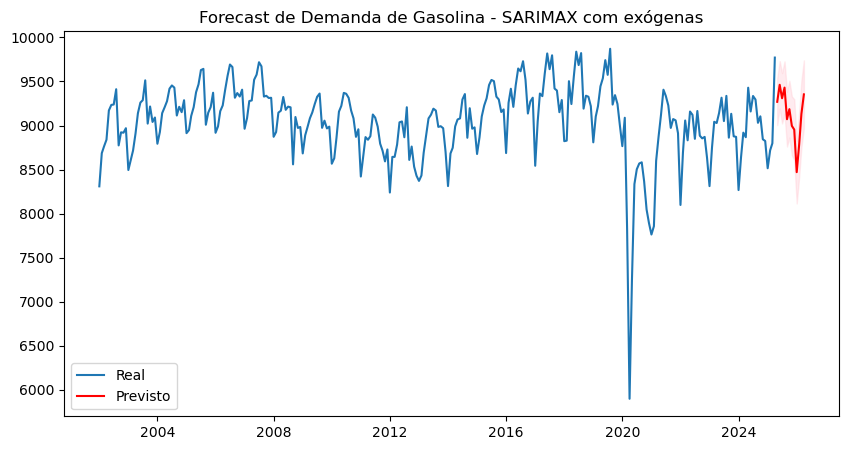

In [227]:
# Gráfico (com variáveis exógenas).

exog_future = exog_vars.iloc[-12:].copy()
exog_future.index = pd.date_range(serie.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq='MS')

forecast = resultado.get_forecast(steps=12, exog=exog_future)
pred = forecast.predicted_mean
conf = forecast.conf_int()

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(serie, label='Real')
plt.plot(pred, label='Previsto', color='r')
plt.fill_between(conf.index, conf.iloc[:, 0], conf.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Forecast de Demanda de Gasolina - SARIMAX com exógenas')
plt.show()


**Conclusão modelagem:**

Durante o desenvolvimento deste desafio, considerei certas abordagens para previsão da demanda de petróleo e derivados, incluindo métodos estatísticos tradicionais (como OLS e SARIMAX) e modelos de machine learning (como Random Forest). Após testar e comparar os resultados, optei por priorizar os modelos tradicionais por três razões principais:

* Desempenho: Os modelos OLS e SARIMAX apresentaram desempenho superior ou equivalente aos modelos de machine learning nas séries temporais econômicas analisadas, conforme as principais métricas de ajuste.

* Interpretação: Os modelos estatísticos oferecem maior transparência e facilidade de interpretação dos coeficientes, facilitando a análise das elasticidades e do impacto de cada variável sobre a demanda.

* Aderência ao contexto: Em séries temporais econômicas regulares, métodos lineares e ARIMA são amplamente aceitos e, muitas vezes, preferidos no mercado por sua robustez e clareza na comunicação dos resultados.

Portanto, os modelos apresentados são os que melhor equilibram precisão preditiva e explicabilidade. O uso de técnicas de machine learning pode ser explorado em etapas futuras, especialmente caso haja ampliação do escopo de dados ou busca por padrões mais complexos.

In [236]:
# histórico e previsão
df_hist['tipo'] = 'real'
df_forecast = df_forecast.rename(columns={'Demand_pred': 'Demand'})
df_forecast['tipo'] = 'previsto'

df_export = pd.concat([df_hist, df_forecast[['date', 'Demand', 'conf_lower', 'conf_upper', 'tipo']]], ignore_index=True)
df_export.to_csv('gasolina_hist_prev.csv', index=False)


In [237]:
# CSV com todas as variáveis históricas
df_exog = exog_vars.copy()
df_exog['date'] = df_exog.index
df_exog.to_csv('gasolina_exogenas_historico.csv', index=False)


In [240]:
## Middle
#Modelagem usando Sarimax (sem variáveis exógenas)

serie_middle = df_middle_final.set_index('date')['Demand'].sort_index()

modelo_middle = SARIMAX(serie_middle, order=(1,1,1), seasonal_order=(1,1,1,12))
resultado_middle = modelo_middle.fit(disp=False)

print(resultado_middle.summary())

C:\Users\Marcos\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Marcos\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             Demand   No. Observations:                  280
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1862.154
Date:                            Sun, 29 Jun 2025   AIC                           3734.308
Time:                                    23:41:29   BIC                           3752.244
Sample:                                01-01-2002   HQIC                          3741.513
                                     - 04-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0474      0.297     -0.159      0.873      -0.630       0.535
ma.L1         -0.1732      0.282   

Modelo utilizando apenas a própria série de demanda histórica para prever os próximos períodos, com componentes autorregressivos e sazonais.

Parâmetros: Nenhum dos coeficientes AR ou MA (nem normal nem sazonal) é estatisticamente significativo (veja o P>|z|), pois todos têm p-valores bem acima de 0,05. O componente sazonal MA chega a ser bem alto em valor absoluto, mas tem erro padrão grande e não é significativo.

Qualidade: O AIC ficou em 3734. O modelo pode captar parte da tendência e da sazonalidade, mas provavelmente não explica muito bem as variações, já que os parâmetros não foram significativos.

Resíduos: Os resíduos mostram sinais de não-normalidade e alta curtose (veja o Jarque-Bera), o que sugere que há eventos extremos ou outliers não capturados.

In [241]:
# 2.2) Testando Sarimax para demanda de Middle (com variáveis exógenas)

serie_middle = df_middle_final.set_index('date')['Demand'].sort_index()

exog_vars_middle = df_middle_final.set_index('date')[['WTI_real', 'Industrial_Production', 'Freight_Transp', 'Unemployment', 'CPI']]
exog_vars_middle = exog_vars_middle.loc[serie_middle.index]  # Garante alinhamento

# Removendo NaNs (tanto da série quanto das exógenas)
mask_middle = (~serie_middle.isna()) & (~exog_vars_middle.isna().any(axis=1))
serie_middle = serie_middle[mask_middle]
exog_vars_middle = exog_vars_middle[mask_middle]

modelo_middle_exog = SARIMAX(serie_middle, 
                             exog=exog_vars_middle,
                             order=(1,1,1), 
                             seasonal_order=(1,1,1,12),
                             enforce_stationarity=False,
                             enforce_invertibility=False)

resultado_middle_exog = modelo_middle_exog.fit(disp=False, maxiter=200)
print(resultado_middle_exog.summary())


C:\Users\Marcos\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Marcos\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             Demand   No. Observations:                  280
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1717.239
Date:                            Sun, 29 Jun 2025   AIC                           3454.478
Time:                                    23:42:35   BIC                           3489.812
Sample:                                01-01-2002   HQIC                          3468.694
                                     - 04-01-2025                                         
Covariance Type:                              opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
WTI_real                 -1.6969      1.629     -1.042      0.297      -4.889       1.495
In

Modelo incorporando variáveis econômicas para tentar explicar a demanda por Middle.

Parâmetros:

Unemployment: Coeficiente negativo e altamente significativo (p < 0,001). Ou seja, aumento da taxa de desemprego está associado a uma forte queda na demanda por Middle.

WTI_real, Ind.Prod, Freight, CPI: Todos com p-valor alto, ou seja, não são estatisticamente significativos na explicação da demanda no modelo atual.

Componentes sazonais (ar.S.L12, ma.S.L12): A sazonalidade segue importante e significativa (veja ma.S.L12, p-valor < 0,001).

Qualidade: O AIC caiu para 3454, indicando ajuste bem melhor comparado ao modelo sem exógenas.

Resíduos: Embora tenha melhorado, ainda existem problemas de normalidade (curtose alta) e indícios de possíveis outliers ou choques não modelados

Observação: ao contrário do modelo de gasolina, onde o Sarima conseguiu trazer bons insights, esta forma de estimação não conseguiu trazer bons proveitos para o caso de Middle.

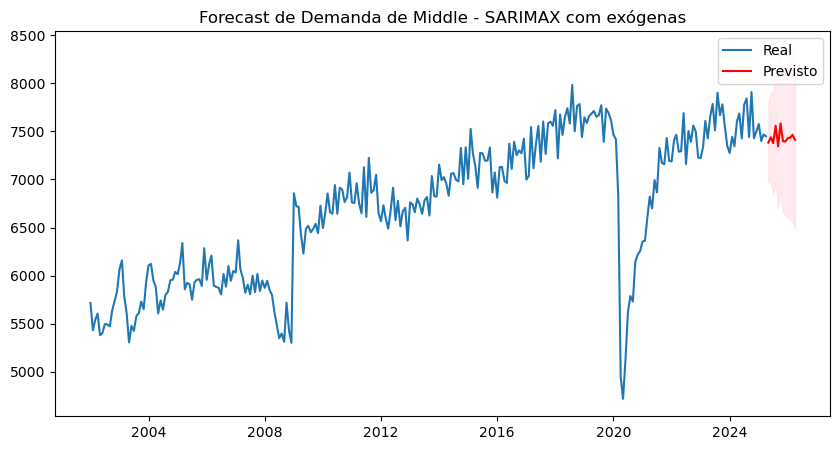

In [242]:
exog_future_middle = exog_vars_middle.iloc[-12:].copy()
exog_future_middle.index = pd.date_range(serie_middle.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq='MS')

forecast_middle = resultado_middle_exog.get_forecast(steps=12, exog=exog_future_middle)
pred_middle = forecast_middle.predicted_mean
conf_middle = forecast_middle.conf_int()

plt.figure(figsize=(10,5))
plt.plot(serie_middle, label='Real')
plt.plot(pred_middle, label='Previsto', color='r')
plt.fill_between(conf_middle.index, conf_middle.iloc[:, 0], conf_middle.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Forecast de Demanda de Middle - SARIMAX com exógenas')
plt.show()

In [243]:
#Exportando histórico e previsão

df_middle_hist = df_middle_final[['date', 'Demand']].copy()
df_middle_hist['tipo'] = 'real'

# Forecast para exportar
df_middle_forecast = pd.DataFrame({
    'date': pred_middle.index,
    'Demand': pred_middle.values,
    'conf_lower': conf_middle.iloc[:, 0].values,
    'conf_upper': conf_middle.iloc[:, 1].values,
    'tipo': 'previsto'
})

# Concatenando histórico + previsão
df_middle_export = pd.concat([df_middle_hist, df_middle_forecast], ignore_index=True)
df_middle_export.to_csv('middle_hist_prev.csv', index=False)

In [244]:
# Exportando exógenas

df_middle_exog = exog_vars_middle.copy()
df_middle_exog['date'] = df_middle_exog.index
df_middle_exog.to_csv('middle_exogenas_historico.csv', index=False)